<a href="https://colab.research.google.com/github/gbouzioto/chemical_polution/blob/main/notebooks/model_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statements

In [1]:
import os
import numpy
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.applications import InceptionV3, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import get_file
from tensorflow import expand_dims
from tensorflow.nn import softmax

from sklearn.metrics import classification_report, confusion_matrix

## Load Dataset

In [2]:
project_dir = os.path.join('C:/Users/Nikiforos/anaconda3/', 'content')
dataset_file = os.path.join(project_dir, 'BlackSea.zip')
dataset_file_path = os.path.join(project_dir, 'BlackSea')

if not os.path.isdir(dataset_file_path):
    # download dataset if it does not exist
    url = 'http://dsfp.chem.uoa.gr/BlackSea/Predicted%20spatial%20distribution%20dataset.zip'
    urllib.request.urlretrieve(url, dataset_file)
    # extract images
    with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_file_path)

dataset_train = os.path.join(dataset_file_path, 'train')
dataset_evaluation = os.path.join(dataset_file_path, 'evaluation')

In [3]:
dataset_train

'C:/Users/Nikiforos/anaconda3/content\\BlackSea\\train'

In [4]:
dataset_evaluation

'C:/Users/Nikiforos/anaconda3/content\\BlackSea\\evaluation'

## Data Augmentation

### Train, Validation and Test Generators

In [5]:
datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

In [6]:
train_generator = datagen.flow_from_directory(
    dataset_train, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training')

Found 1126 images belonging to 3 classes.


In [7]:
validation_generator = datagen.flow_from_directory(
    dataset_train, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation')

Found 280 images belonging to 3 classes.


In [8]:
test_generator = datagen.flow_from_directory(
    dataset_evaluation, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical')

Found 224 images belonging to 3 classes.


The number of images are correct. We have in total 1406 which were split in training set (1126 images) and validation set (280 images). Finally there are 224 images as the test set.

In [9]:
test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)
print(test_steps_per_epoch)

7


# Baseline model implementation

Set the architecture of the neural network model

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1500, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

Set the loss and the optimizer function

In [11]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tfa.metrics.F1Score(num_classes=3)])

In [12]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3
)

Epoch 1/3
36/36 [==============================] - ETA: 0s - loss: 85.3347 - f1_score: 0.4401

C:\Users\Nikiforos\anaconda3\envs\Thesis\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


36/36 [==============================] - 20s 541ms/step - loss: 85.3347 - f1_score: 0.4401 - val_loss: 8.2208 - val_f1_score: 0.5517
Epoch 2/3
36/36 [==============================] - 19s 529ms/step - loss: 3.9443 - f1_score: 0.7482 - val_loss: 0.4328 - val_f1_score: 0.9234
Epoch 3/3
36/36 [==============================] - 19s 530ms/step - loss: 1.8753 - f1_score: 0.8150 - val_loss: 0.1572 - val_f1_score: 0.9729


### Classification Report and Confusion Matrix Results

In [14]:
score = model.evaluate(test_generator, verbose=0)
score

[0.4487943649291992, array([0.9468599, 0.9629629, 0.8101266], dtype=float32)]

In [15]:
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4487943649291992
Test accuracy: [0.9468599 0.9629629 0.8101266]


In [21]:
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predictions

array([[5.28960891e-31, 1.00000000e+00, 3.96275271e-13],
       [1.26442558e-25, 1.00000000e+00, 2.11709209e-12],
       [3.43328906e-26, 2.31470263e-26, 1.00000000e+00],
       [2.00659990e-01, 6.17422449e-25, 7.99340010e-01],
       [1.44581839e-37, 1.00000000e+00, 7.09406221e-13],
       [1.00000000e+00, 4.14792588e-28, 1.86033731e-08],
       [5.37439553e-34, 1.00000000e+00, 1.85011837e-15],
       [5.26362522e-30, 1.00000000e+00, 8.24708615e-14],
       [9.99999881e-01, 4.59174129e-34, 9.63675575e-08],
       [3.74817349e-25, 8.71297826e-12, 1.00000000e+00],
       [7.92887747e-01, 1.02908343e-30, 2.07112312e-01],
       [1.36107918e-36, 1.00000000e+00, 9.06977998e-16],
       [1.32943863e-27, 9.99976635e-01, 2.33965857e-05],
       [1.00000000e+00, 0.00000000e+00, 1.75048812e-11],
       [7.36242265e-27, 1.00000000e+00, 1.24448941e-11],
       [3.05510810e-35, 1.00000000e+00, 9.63343361e-15],
       [9.99816358e-01, 3.33292872e-33, 1.83713797e-04],
       [7.89387504e-35, 1.00000

In [22]:
predicted_classes= numpy.argmax(predictions, axis=1)
predicted_classes

array([1, 1, 2, 2, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 2, 0, 2, 0, 1, 0, 0,
       0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0,
       0, 2, 0, 2, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 1,
       1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 2, 0, 1,
       0, 0, 1, 0, 2, 0, 2, 0, 1, 2, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 2, 2,
       0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 0,
       2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0,
       2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 0, 0,
       0, 2, 1, 1], dtype=int64)

In [23]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [24]:
class_labels = list(test_generator.class_indices.keys())
class_labels

['Danube', 'Dnieper', 'UnknownOrigin']

In [26]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)

               precision    recall  f1-score   support

       Danube       0.50      0.45      0.47       109
      Dnieper       0.38      0.41      0.40        78
UnknownOrigin       0.19      0.22      0.20        37

     accuracy                           0.40       224
    macro avg       0.36      0.36      0.36       224
 weighted avg       0.41      0.40      0.40       224



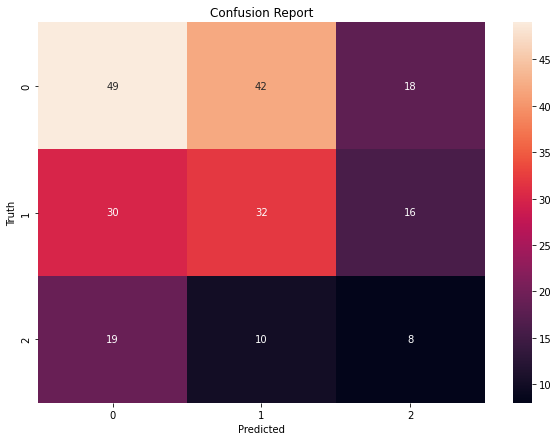

In [27]:
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()

# Convolutional neural network

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
batch_size = 6
img_height = 200
img_width = 280

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/Nikiforos/anaconda3/content/BlackSea/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1406 files belonging to 3 classes.
Using 1125 files for training.


In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/Nikiforos/anaconda3/content/BlackSea/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1406 files belonging to 3 classes.
Using 281 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['Danube', 'Dnieper', 'UnknownOrigin']


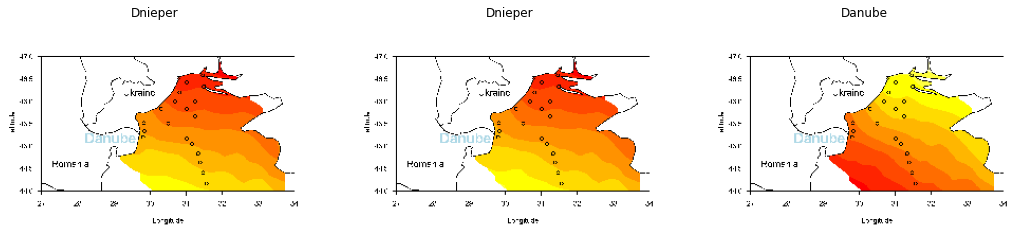

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(6, 200, 280, 3)
(6,)


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [26]:
num_classes = 3


model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
 # layers.Conv2D(16, 3, padding='same', activation='relu'),
 # layers.MaxPooling2D(),
 # layers.Conv2D(32, 3, padding='same', activation='relu'),
 # layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['acc',f1_m,precision_m, recall_m])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 200, 280, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 280, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 140, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 140, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 70, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 35, 64)       

In [30]:
train_ds

<PrefetchDataset shapes: ((None, 200, 280, 3), (None,)), types: (tf.float32, tf.int32)>

In [31]:
val_ds

<PrefetchDataset shapes: ((None, 200, 280, 3), (None,)), types: (tf.float32, tf.int32)>

In [32]:
epochs=15

In [33]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
188/188 [==============================] - 6s 21ms/step - loss: 0.3548 - acc: 0.8969 - f1_m: 0.7896 - precision_m: 53192.0977 - recall_m: 1.5122 - val_loss: 0.0225 - val_acc: 0.9929 - val_f1_m: 0.7175 - val_precision_m: 0.5116 - val_recall_m: 1.3078
Epoch 2/15
188/188 [==============================] - 3s 16ms/step - loss: 0.0501 - acc: 0.9876 - f1_m: 0.8272 - precision_m: 0.5970 - recall_m: 1.4809 - val_loss: 0.0518 - val_acc: 0.9893 - val_f1_m: 0.7516 - val_precision_m: 0.5473 - val_recall_m: 1.2943
Epoch 3/15
188/188 [==============================] - 3s 16ms/step - loss: 0.1490 - acc: 0.9618 - f1_m: 0.8135 - precision_m: 0.5998 - recall_m: 1.4065 - val_loss: 0.0328 - val_acc: 0.9893 - val_f1_m: 0.7981 - val_precision_m: 0.5774 - val_recall_m: 1.4436
Epoch 4/15
188/188 [==============================] - 3s 16ms/step - loss: 0.0520 - acc: 0.9884 - f1_m: 0.7668 - precision_m: 0.5784 - recall_m: 1.2256 - val_loss: 0.0190 - val_acc: 0.9929 - val_f1_m: 0.6775 - val_precision_m

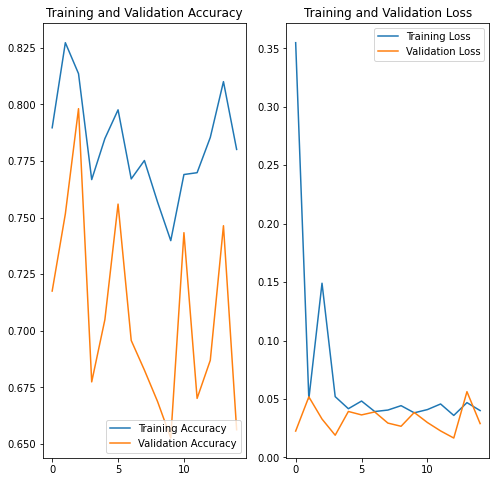

In [34]:
acc = history.history['f1_m']
val_acc = history.history['val_f1_m']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/Nikiforos/anaconda3/content/BlackSea/evaluation',
  validation_split=0.01,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: name 'img_height' is not defined

In [45]:
predictions = model.predict(test_ds, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

In [50]:
true_classes = test_ds.class_names
true_classes

['Danube', 'Dnieper', 'UnknownOrigin']

In [51]:
class_labels = list(test_ds.class_names_indices.keys())

In [52]:

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [3, 42]

# Transfer learning

## ResNet50

### Initialization and Summary

In [ ]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add a dropout layer
x = Dropout(0.2)(x)
# and a logistic layer -- we have 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Model Training

In [ ]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=1126//32,
    epochs=14,
    validation_steps=280//32)

Epoch 1/14
35/35 [==============================] - 30s 790ms/step - loss: 1.0122 - accuracy: 0.5338 - val_loss: 0.8317 - val_accuracy: 0.6367
Epoch 2/14
35/35 [==============================] - 26s 748ms/step - loss: 0.7628 - accuracy: 0.7349 - val_loss: 0.7381 - val_accuracy: 0.6094
Epoch 3/14
35/35 [==============================] - 26s 744ms/step - loss: 0.6284 - accuracy: 0.8035 - val_loss: 0.5965 - val_accuracy: 0.9102
Epoch 4/14
35/35 [==============================] - 26s 740ms/step - loss: 0.4988 - accuracy: 0.8565 - val_loss: 0.4244 - val_accuracy: 0.8672
Epoch 5/14
35/35 [==============================] - 26s 744ms/step - loss: 0.4386 - accuracy: 0.8565 - val_loss: 0.3724 - val_accuracy: 0.9258
Epoch 6/14
35/35 [==============================] - 26s 742ms/step - loss: 0.3496 - accuracy: 0.8967 - val_loss: 0.3009 - val_accuracy: 0.8906
Epoch 7/14
35/35 [==============================] - 26s 749ms/step - loss: 0.3159 - accuracy: 0.9113 - val_loss: 0.2576 - val_accuracy: 0.9258

### Model Accuracy

In [ ]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2832943797111511
Test accuracy: 0.8616071343421936


### Classification Report and Confusion Matrix Results

               precision    recall  f1-score   support

       Danube       0.89      1.00      0.94       109
      Dnieper       0.82      1.00      0.90        78
UnknownOrigin       1.00      0.16      0.28        37

     accuracy                           0.86       224
    macro avg       0.90      0.72      0.71       224
 weighted avg       0.88      0.86      0.82       224



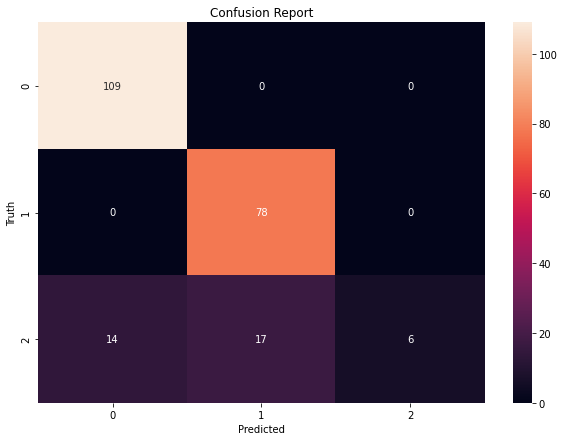

In [ ]:
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()


## InceptionV3

### Initialization and Summary

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add a dropout layer
x = Dropout(0.2)(x)
# and a logistic layer -- we have 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
___________________________

### Model Training

In [ ]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=1126//32,
    epochs=5,
    validation_steps=280//32)

Epoch 1/5
35/35 [==============================] - 31s 771ms/step - loss: 1.1153 - accuracy: 0.6746 - val_loss: 0.3353 - val_accuracy: 0.8945
Epoch 2/5
35/35 [==============================] - 26s 733ms/step - loss: 0.2571 - accuracy: 0.9333 - val_loss: 0.1917 - val_accuracy: 0.9414
Epoch 3/5
35/35 [==============================] - 26s 738ms/step - loss: 0.2115 - accuracy: 0.9287 - val_loss: 0.1302 - val_accuracy: 0.9570
Epoch 4/5
35/35 [==============================] - 25s 729ms/step - loss: 0.1600 - accuracy: 0.9543 - val_loss: 0.1688 - val_accuracy: 0.9492
Epoch 5/5
35/35 [==============================] - 26s 733ms/step - loss: 0.1605 - accuracy: 0.9506 - val_loss: 0.1190 - val_accuracy: 0.9570


### Model Accuracy

In [ ]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03664422780275345
Test accuracy: 0.9910714030265808


### Classification Report and Confusion Matrix Results

               precision    recall  f1-score   support

       Danube       0.98      1.00      0.99       109
      Dnieper       1.00      0.97      0.99        78
UnknownOrigin       1.00      1.00      1.00        37

     accuracy                           0.99       224
    macro avg       0.99      0.99      0.99       224
 weighted avg       0.99      0.99      0.99       224



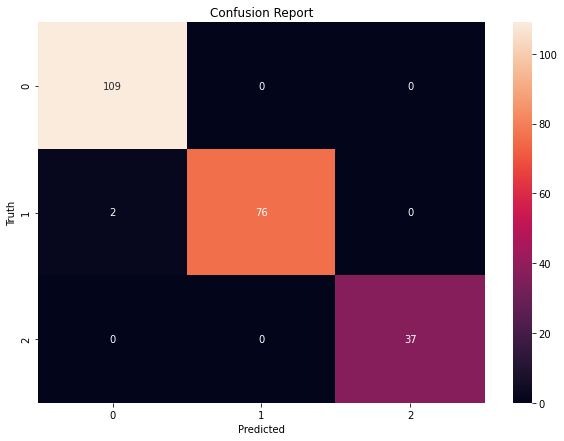

In [ ]:
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()

## MobileNetV2

### Initialization and Summary

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add a dropout layer
x = Dropout(0.2)(x)
# and a logistic layer -- we have 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_____________________________

### Model Training

In [ ]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=1126//32,
    epochs=9,
    validation_steps=280//32)

Epoch 1/9
35/35 [==============================] - 29s 763ms/step - loss: 0.4266 - accuracy: 0.8912 - val_loss: 0.0344 - val_accuracy: 0.9922
Epoch 2/9
35/35 [==============================] - 25s 724ms/step - loss: 0.1032 - accuracy: 0.9771 - val_loss: 0.1260 - val_accuracy: 0.9648
Epoch 3/9
35/35 [==============================] - 25s 711ms/step - loss: 0.1093 - accuracy: 0.9726 - val_loss: 0.0133 - val_accuracy: 0.9961
Epoch 4/9
35/35 [==============================] - 25s 713ms/step - loss: 0.0866 - accuracy: 0.9753 - val_loss: 0.2561 - val_accuracy: 0.8984
Epoch 5/9
35/35 [==============================] - 25s 711ms/step - loss: 0.0968 - accuracy: 0.9735 - val_loss: 0.1049 - val_accuracy: 0.9570
Epoch 6/9
35/35 [==============================] - 25s 713ms/step - loss: 0.0909 - accuracy: 0.9735 - val_loss: 0.0363 - val_accuracy: 0.9883
Epoch 7/9
35/35 [==============================] - 25s 714ms/step - loss: 0.0846 - accuracy: 0.9781 - val_loss: 0.0219 - val_accuracy: 0.9922
Epoch 

### Model Accuracy

In [ ]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.20453548431396484
Test accuracy: 0.9285714030265808


### Classification Report and Confusion Matrix Results

               precision    recall  f1-score   support

       Danube       1.00      0.85      0.92       109
      Dnieper       1.00      1.00      1.00        78
UnknownOrigin       0.70      1.00      0.82        37

     accuracy                           0.93       224
    macro avg       0.90      0.95      0.91       224
 weighted avg       0.95      0.93      0.93       224



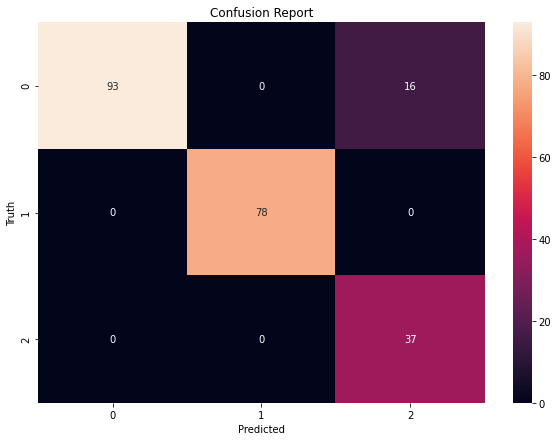

In [ ]:
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()